<a href="https://colab.research.google.com/github/IvanKatorgin/Deep-Learning/blob/main/Deep_Learning_%D0%B4%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Курс "Deep Learning". Домашнее задание 11. Компьютерное зрение 2. Каторгин И.П.

## Задание
Обучить UNet сегментировать сгенерированные кружочки

Код для генерации тут: https://colab.research.google.com/drive/1Fum-Udmayf60qfJAl4N5z8hgUH6_uoTc

In [1]:
# загрузим библиотеки
import os
import random
import shutil

from multiprocessing.dummy import Pool

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

import cv2

from PIL import Image

from sklearn.model_selection import train_test_split

from skimage.morphology import binary_opening, disk, label

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

import torchvision.transforms as transforms

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
class BaseDataProvider(object):
    channels = 1
    n_class = 2

    def __init__(self, a_min=None, a_max=None):
        self.a_min = a_min if a_min is not None else -np.inf
        self.a_max = a_max if a_min is not None else np.inf

    def _load_data_and_label(self):
        data, label = self._next_data()

        train_data = self._process_data(data)
        labels = self._process_labels(label)

        train_data, labels = self._post_process(train_data, labels)

        nx = train_data.shape[1]
        ny = train_data.shape[0]

        return train_data.reshape(1, ny, nx, self.channels), labels.reshape(1, ny, nx, self.n_class),

    def _process_labels(self, label):
        if self.n_class == 2:
            nx = label.shape[1]
            ny = label.shape[0]
            labels = np.zeros((ny, nx, self.n_class), dtype=np.float32)

            # It is the responsibility of the child class to make sure that the label
            # is a boolean array, but we a chech here just in case.
            if label.dtype != 'bool':
                label = label.astype(np.bool)

            labels[..., 1] = label
            labels[..., 0] = ~label
            return labels

        return label

    def _process_data(self, data):
        # normalization
        data = np.clip(np.fabs(data), self.a_min, self.a_max)
        data -= np.amin(data)

        if np.amax(data) != 0:
            data /= np.amax(data)

        return data

    def _post_process(self, data, labels):
        """
        Post processing hook that can be used for data augmentation
        :param data: the data array
        :param labels: the label array
        """
        return data, labels

    def __call__(self, n):
        train_data, labels = self._load_data_and_label()
        nx = train_data.shape[1]
        ny = train_data.shape[2]

        X = np.zeros((n, nx, ny, self.channels))
        Y = np.zeros((n, nx, ny, self.n_class))

        X[0] = train_data
        Y[0] = labels
        for i in range(1, n):
            train_data, labels = self._load_data_and_label()
            X[i] = train_data
            Y[i] = labels

        return X, Y

class GrayScaleDataProvider(BaseDataProvider):
    channels = 1
    n_class = 2

    def __init__(self, nx, ny, **kwargs):
        super(GrayScaleDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3

    def _next_data(self):
        return create_image_and_label(self.nx, self.ny, **self.kwargs)

class RgbDataProvider(BaseDataProvider):
    channels = 3
    n_class = 2

    def __init__(self, nx, ny, **kwargs):
        super(RgbDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3


    def _next_data(self):
        data, label = create_image_and_label(self.nx, self.ny, **self.kwargs)
        return to_rgb(data), label

def create_image_and_label(nx, ny, cnt, r_min=5, r_max=20, border=10, sigma=1.0, rectangles=False):

  # Добавляем проверки параметров
    border = min(border, nx//4, ny//4)
    if border <= 0:
        border = 5  # Минимальное значение
    if r_min >= r_max:
        r_max = r_min + 5  # Корректируем радиусы

    image = np.ones((nx, ny, 1))
    label = np.zeros((nx, ny, 3), dtype=np.bool)
    mask = np.zeros((nx, ny), dtype=np.bool)
    for _ in range(cnt):
        a = np.random.randint(border, nx-border)
        b = np.random.randint(border, ny-border)
        r = np.random.randint(r_min, r_max)
        h = np.random.randint(1,255)

        y,x = np.ogrid[-a:nx-a, -b:ny-b]
        m = x*x + y*y <= r*r
        mask = np.logical_or(mask, m)

        image[m] = h

    label[mask, 1] = 1

    if rectangles:
        mask = np.zeros((nx, ny), dtype=np.bool)
        for _ in range(cnt//2):
            a = np.random.randint(nx)
            b = np.random.randint(ny)
            r =  np.random.randint(r_min, r_max)
            h = np.random.randint(1,255)

            m = np.zeros((nx, ny), dtype=np.bool)
            m[a:a+r, b:b+r] = True
            mask = np.logical_or(mask, m)
            image[m] = h

        label[mask, 2] = 1

        label[..., 0] = ~(np.logical_or(label[...,1], label[...,2]))

    image += np.random.normal(scale=sigma, size=image.shape)
    image -= np.amin(image)
    image /= np.amax(image)

    if rectangles:
        return image, label
    else:
        return image, label[..., 1]




def to_rgb(img):
    img = img.reshape(img.shape[0], img.shape[1])
    img[np.isnan(img)] = 0
    img -= np.amin(img)
    img /= np.amax(img)
    blue = np.clip(4*(0.75-img), 0, 1)
    red  = np.clip(4*(img-0.25), 0, 1)
    green= np.clip(44*np.fabs(img-0.5)-1., 0, 1)
    rgb = np.stack((red, green, blue), axis=2)
    return rgb


In [3]:
nx = 572
ny = 572

In [4]:
generator = GrayScaleDataProvider(nx, ny, cnt=20)

In [5]:
x_test, y_test = generator(1)

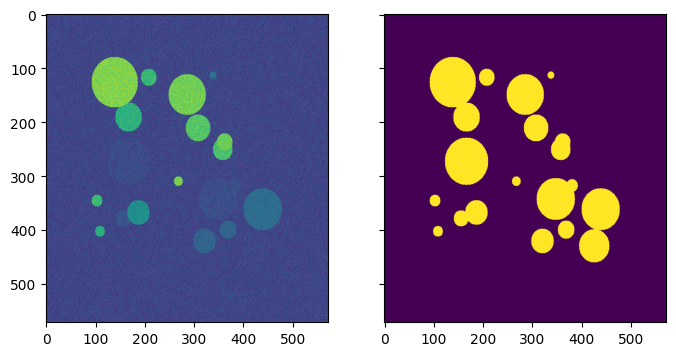

In [6]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[1].imshow(y_test[0,...,1], aspect="auto")

In [7]:
y_test[0,...,1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Обучим UNet сегментировать сгенерированные кружочки

Прежде чем двигаться дальше прочитать внимательно. При размерах изображения 572х572 и 256х256 модель не обсчитывается, т.к. не хватает пямяти и вылезает сообщение:

OutOfMemoryError: CUDA out of memory. Tried to allocate 614.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 550.12 MiB is free. Process 12709 has 14.20 GiB memory in use. Of the allocated memory 13.54 GiB is allocated by PyTorch, and 552.88 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Для того, чтобы выполнить задание принято решение уменьшить размеры изображений до 128х128

In [271]:
# для воспроизводимости результатов
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.cuda.manual_seed_all(42)
# Дополнительные настройки PyTorch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [272]:
# Определяем архитектуру UNet для 128x128
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(in_channels, 32)
        self.enc2 = self.conv_block(32, 64)
        self.enc3 = self.conv_block(64, 128)
        self.enc4 = self.conv_block(128, 256)

        self.pool = nn.MaxPool2d(2, 2)

        # Bottleneck
        self.bottleneck = self.conv_block(256, 512)

        # Decoder
        self.upconv4 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.dec4 = self.conv_block(512, 256)

        self.upconv3 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.dec3 = self.conv_block(256, 128)

        self.upconv2 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.dec2 = self.conv_block(128, 64)

        self.upconv1 = nn.ConvTranspose2d(64, 32, 2, 2)
        self.dec1 = self.conv_block(64, 32)

        self.out = nn.Conv2d(32, out_channels, 1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)       # 128 -> 128
        enc2 = self.enc2(self.pool(enc1))  # 64
        enc3 = self.enc3(self.pool(enc2))  # 32
        enc4 = self.enc4(self.pool(enc3))  # 16

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))  # 8

        # Decoder
        dec4 = self.upconv4(bottleneck)  # 16
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)  # 32
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)  # 64
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)  # 128
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.dec1(dec1)

        return self.out(dec1)

In [273]:
# Датасет для генерации кругов 128x128
class CircleDataset(Dataset):
    def __init__(self, num_samples=1000, img_size=128, transform=None):
        self.num_samples = num_samples
        self.img_size = img_size
        self.transform = transform
        # Безопасные параметры генерации
        self.border = min(20, img_size//4)
        self.r_min, self.r_max = 5, 15

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Генерация одного изображения с кругом
        image = np.zeros((self.img_size, self.img_size, 1), dtype=np.float32)
        mask = np.zeros((self.img_size, self.img_size, 1), dtype=np.float32)

        # Генерация случайного круга
        x = np.random.randint(self.border, self.img_size-self.border)
        y = np.random.randint(self.border, self.img_size-self.border)
        r = np.random.randint(self.r_min, self.r_max)

        # Рисуем круг в маске
        for i in range(self.img_size):
            for j in range(self.img_size):
                if (i-x)**2 + (j-y)**2 <= r**2:
                    mask[i,j,0] = 1.0
                    image[i,j,0] = 1.0  # Круг белый на черном фоне

        # Добавляем немного шума
        image += np.random.normal(0, 0.1, (self.img_size, self.img_size, 1))
        image = np.clip(image, 0, 1)

        # Преобразуем в тензоры
        image = torch.from_numpy(image.transpose(2, 0, 1))
        mask = torch.from_numpy(mask.transpose(2, 0, 1))

        if self.transform:
            image = self.transform(image)

        return image, mask


In [274]:
# Параметры обучения
BATCH_SIZE = 2   # Уменьшаем размер батча
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
IMG_SIZE = 128  # Уменьшаем размер изображения
NUM_SAMPLES = 1000
patience = 3

# Создадим датасеты и загрузчики
transform = transforms.Compose([transforms.Normalize(mean=[0.5], std=[0.5])])
dataset = CircleDataset(num_samples=NUM_SAMPLES, img_size=IMG_SIZE, transform=transform)

In [275]:
# проверку данных
print("Min:", dataset[0][0].min().item(), "Max:", dataset[0][0].max().item())

Min: -1.0 Max: 1.0


In [276]:
# Разделим на train/val/test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)  # val_dl
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [277]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [278]:
# Инициализация модели, функции потерь и оптимизатора
model = UNet(in_channels=1, out_channels=1).to(device)  # Изменили на out_channels=1
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [279]:
# проверим тип модели
print(type(model).__name__)

UNet


In [280]:
print(model)

UNet(
  (enc1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running

In [281]:
# Функция для вычисления точности
def accuracy(preds, labels):
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    return (preds == labels).float().mean()

In [282]:
def dice_coeff(preds, labels):
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    intersection = (preds * labels).sum()
    return (2. * intersection) / (preds.sum() + labels.sum() + 1e-8)

In [283]:
def evaluate(loader, model, criterion):
    model.eval()
    loss, acc, dice = 0.0, 0.0, 0.0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss += criterion(outputs, masks).item()
            acc += accuracy(outputs, masks).item()
            dice += dice_coeff(outputs, masks).item()
    return loss/len(loader), acc/len(loader), dice/len(loader)

In [284]:
# Инициализация best_val_loss
best_val_loss = float('inf')

In [285]:
# Проверка размерностей перед обучением
sample_img, sample_mask = dataset[0]
print("Image shape:", sample_img.shape)  # Должно быть [1, 128, 128]
print("Mask shape:", sample_mask.shape)  # Должно быть [1, 128, 128]

Image shape: torch.Size([1, 128, 128])
Mask shape: torch.Size([1, 128, 128])


In [286]:
# Проверка архитектуры перед обучением
model = UNet().to(device)
test_input = torch.randn(1, 1, 128, 128).to(device)
test_output = model(test_input)
print("Output shape:", test_output.shape)  # Должно быть (1, 1, 128, 128)
assert test_output.shape == (1, 1, 128, 128)

Output shape: torch.Size([1, 1, 128, 128])


In [287]:
print(f"Доступно памяти на GPU: {torch.cuda.mem_get_info()[0]/1024**3:.2f} GB")
print(f"Используется памяти: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
print(f"Зарезервировано памяти: {torch.cuda.memory_reserved()/1024**3:.2f} GB")

Доступно памяти на GPU: 6.19 GB
Используется памяти: 0.55 GB
Зарезервировано памяти: 8.43 GB


In [288]:
# Обучение модели
train_losses, val_losses = [], []
train_accs, val_accs = [], []
train_dices, val_dices = [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for images, masks in tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS}'):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        acc = accuracy(outputs, masks)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += acc.item()

    # Валидация
    val_loss, val_acc, val_dice = evaluate(val_loader, model, criterion)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improve += 1

    # Сохраняем метрики
    train_loss = running_loss / len(train_loader)
    train_acc = running_acc / len(train_loader)
    train_dice = dice_coeff(outputs, masks).item()
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    train_dices.append(train_dice)
    val_dices.append(val_dice)


    print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
    print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
    print(f'Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}\n')
    print(f"Val Dice: {val_dice:.4f}")

    if no_improve >= patience:
        print("Early stopping triggered")
        print(f"Best Val Loss: {best_val_loss:.4f} at epoch {epoch-no_improve+1}")
        break

if no_improve < patience:  # Если не сработал early stopping
    print(f"Training completed. Best Val Loss: {best_val_loss:.4f} at epoch {NUM_EPOCHS-no_improve}")

Epoch 1/20: 100%|██████████| 350/350 [00:08<00:00, 42.29it/s]


Epoch 1/20
Train Loss: 0.9461 | Val Loss: 0.9438
Train Acc: 0.0427 | Val Acc: 0.0414

Val Dice: 0.0355


Epoch 2/20: 100%|██████████| 350/350 [00:08<00:00, 42.30it/s]


Epoch 2/20
Train Loss: 0.9469 | Val Loss: 0.9498
Train Acc: 0.0423 | Val Acc: 0.0422

Val Dice: 0.0377


Epoch 3/20: 100%|██████████| 350/350 [00:08<00:00, 41.93it/s]


Epoch 3/20
Train Loss: 0.9475 | Val Loss: 0.9400
Train Acc: 0.0418 | Val Acc: 0.0436

Val Dice: 0.0390


Epoch 4/20: 100%|██████████| 350/350 [00:08<00:00, 41.66it/s]


Epoch 4/20
Train Loss: 0.9452 | Val Loss: 0.9416
Train Acc: 0.0432 | Val Acc: 0.0416

Val Dice: 0.0355


Epoch 5/20: 100%|██████████| 350/350 [00:07<00:00, 44.39it/s]


Epoch 5/20
Train Loss: 0.9461 | Val Loss: 0.9462
Train Acc: 0.0425 | Val Acc: 0.0428

Val Dice: 0.0384


Epoch 6/20: 100%|██████████| 350/350 [00:08<00:00, 42.92it/s]


Epoch 6/20
Train Loss: 0.9457 | Val Loss: 0.9432
Train Acc: 0.0428 | Val Acc: 0.0429

Val Dice: 0.0384
Early stopping triggered
Best Val Loss: 0.9400 at epoch 3


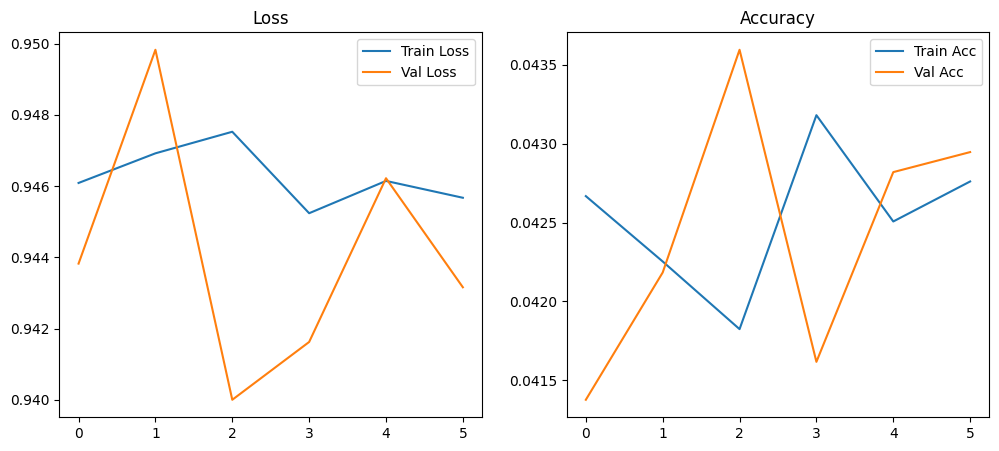

In [318]:
# Визуализация результатов обучения
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

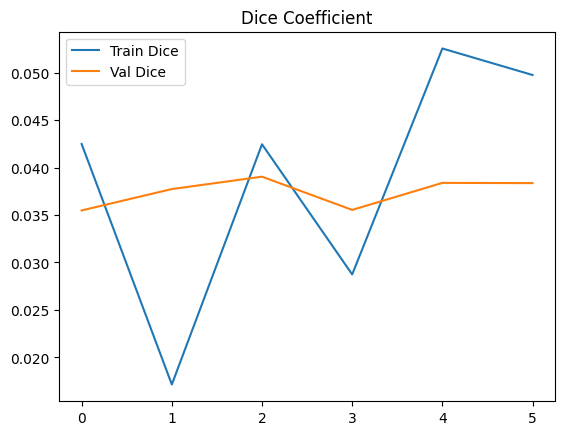

In [290]:
plt.plot(train_dices, label='Train Dice')
plt.plot(val_dices, label='Val Dice')
plt.title('Dice Coefficient')
plt.legend()
plt.show()

In [291]:
# Тестирование
model.load_state_dict(torch.load('best_model.pth'))
test_loss, test_acc, test_dice = evaluate(test_loader, model, criterion)
print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f} | Test Dice: {test_dice:.4f}')

Test Loss: 0.9400 | Test Acc: 0.0415 | Test Dice: 0.0350


In [292]:
# Проверим модель на тестовых данных
model.eval()
with torch.no_grad():
    images, masks = next(iter(test_loader))
    images, masks = images.to(device), masks.to(device)
    outputs = model(images)
    preds = torch.sigmoid(outputs) > 0.5

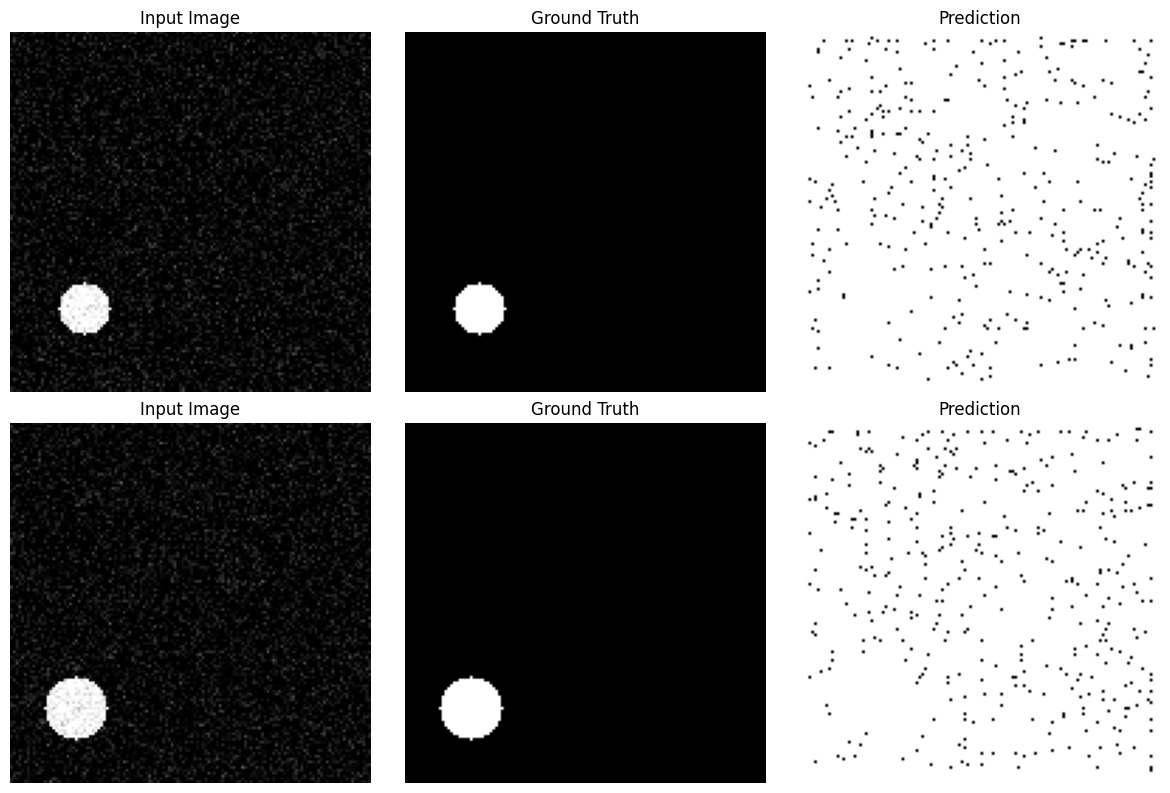

In [333]:
# Визуализация результатов
def plot_results(images, masks, preds, num_samples=2):
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples*4))

    # Ограничиваем количество образцов размером батча
    num_samples = min(num_samples, images.size(0))

    for i in range(num_samples):
        # Изображение
        img = images[i].cpu().squeeze().numpy()  # Явно убираем channel dim


        # Маска
        mask = masks[i].cpu().squeeze().numpy()

        # Предсказание
        pred = preds[i].cpu().squeeze().numpy()

        axes[i, 0].imshow(img, cmap='gray')
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred, cmap='gray')
        axes[i, 2].set_title('Prediction')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

plot_results(images, masks, preds)

В работе обучена архитектура UNet сегментировать сгенерированные кружочки